# Fireveg DB - graph of existing sources of plant trait data

Author: [José R. Ferrer-Paris](https://github.com/jrfep) and [Ada Sánchez-Mercado](https://github.com/adasanchez)

Date: July 2024

This Jupyter Notebook includes R code to visualise data from the Fireveg Database. 

The input is loaded from a public data record of the database.

We use this code to create a graph of traits (labelled rectangles) per published source (circles) used to document 14 fire ecology traits. Size of rectangles and circles is proportional to number of species with data from each trait/source.


## Set-up

### Load packages

In [1]:
library(ggplot2)
library(dplyr)
require(tidyr)
library(igraph)
library(ggraph)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr


Attaching package: ‘igraph’


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [2]:
here::i_am("database-summary/Existing-sources-traits.ipynb")


here() starts at /Users/z3529065/proyectos/fireveg/fireveg-analysis



Download data from OSF if not present

In [16]:
data_dir <- here::here("data")
if (!dir.exists(data_dir))
    dir.create(data_dir)

RDSfile <- here::here(data_dir,'Summary-traits-sources.rds')

if (file.exists(RDSfile)) {
    cat(sprintf("RDS file found at:\n%s\nNo need to download!", RDSfile))
} else {
    require(osfr)
    osf_project <- osf_retrieve_node("https://osf.io/h96q2")
    file_list <- osf_ls_files(osf_project, pattern="Summary-traits-sources.rds")
    osf_download(file_list,
             data_dir,
             conflicts = "overwrite")
}

RDS file found at:
/Users/z3529065/proyectos/fireveg/fireveg-analysis/data/Summary-traits-sources.rds
No need to download!

Read the data from the data folder

In [17]:
traits_table <- readRDS(here::here(data_dir,'Summary-traits-sources.rds'))
# trait_info <- readRDS(here::here('data','Trait-info.rds'))


## Visualise graph of references
### Create the graph

In [5]:
links <- traits_table %>% 
    group_by(from=primary_source, to=traitcode, main_source ) %>% 
    summarise(spp=n_distinct(spp), .groups="drop") # or keep?

In [6]:
nrow(links)

[1] 567

In [7]:
node1 <- traits_table %>% 
    group_by(id=primary_source, type="ref") %>% 
    summarise(spp=n_distinct(spp), .groups="drop")
node2 <- traits_table %>% 
    group_by(id=traitcode, type="trait", label=traitcode) %>% 
    summarise(spp=n_distinct(spp), .groups="drop")

The object `node1` represents the sources (references) and the object `node2` represents the traits: 

In [30]:
nrow(node1)

[1] 269

In [9]:
nrow(node2)

[1] 14

In [8]:
nodes <- bind_rows(node1,node2)

In [10]:
links %>% slice_sample(n=10)

from,to,main_source,spp
<chr>,<chr>,<chr>,<int>
Hodgkinson Griffin 1982,surv1,NSWFFRDv2.1,15
Pannell Myerscough 1993,surv1,NSWFFRDv2.1,3
Chesterfield Taylor Molnar 1990,germ1,NSWFFRDv2.1,4
Duncan 1992,surv5,NSWFFRDv2.1,1
Lunt 1998,surv5,NSWFFRDv2.1,2
EcoGIS 2002,repr4,NSWFFRDv2.1,3
Adrian Pyrke Tas. unpub.,surv1,NSWFFRDv2.1,1
Keith How Proc.Linn.Soc.NSW Keith unpub.,surv1,NSWFFRDv2.1,50
Noble Slatyer 1980,rect2,NSWFFRDv2.1,1


In [11]:
traits_graph <- graph_from_data_frame(links,nodes,directed=F)


In [12]:
E(traits_graph)

+ 567/567 edges from 92f0af5 (vertex names):
 [1] Adrian Pyrke Tas. unpub. --surv1 Angevin 2011             --disp1
 [3] Ashton Chappill 1989     --rect2 Ashton Chappill 1989     --repr3
 [5] Ashton Chappill 1989     --surv1 Ashton Chappill 1989     --surv5
 [7] Auld 1987                --repr3 Auld 1987                --surv1
 [9] Auld 1987                --surv5 Auld 1987                --surv6
[11] Auld 1987                --surv7 Auld 1991                --surv1
[13] Auld Keith Bradstock 2000--surv6 Auld Keith Bradstock 2000--surv7
[15] Auld Scott 1997          --germ1 Auld Scott 1997          --rect2
[17] Auld Scott 1997          --repr3 Auld Scott 1997          --surv1
[19] Auld Scott 1997          --surv5 Auld Scott 1997          --surv6
+ ... omitted several edges

### Visualisation with igraph

In [13]:
colrC <- c(ref = "orange", trait = "skyblue")
shapeC <- c(ref = "circle", trait = "csquare")
V(traits_graph)$color<- colrC[V(traits_graph)$type]
V(traits_graph)$shape<- shapeC[V(traits_graph)$type]
#change vertex size and edge color:
E(traits_graph)$edge.color <- "gray80"
V(traits_graph)$size <- log1p(V(traits_graph)$spp)*ifelse(V(traits_graph)$type=="ref",1,1.45)
#V(g)$size[V(g)$class %in% "EFG"] <- 6

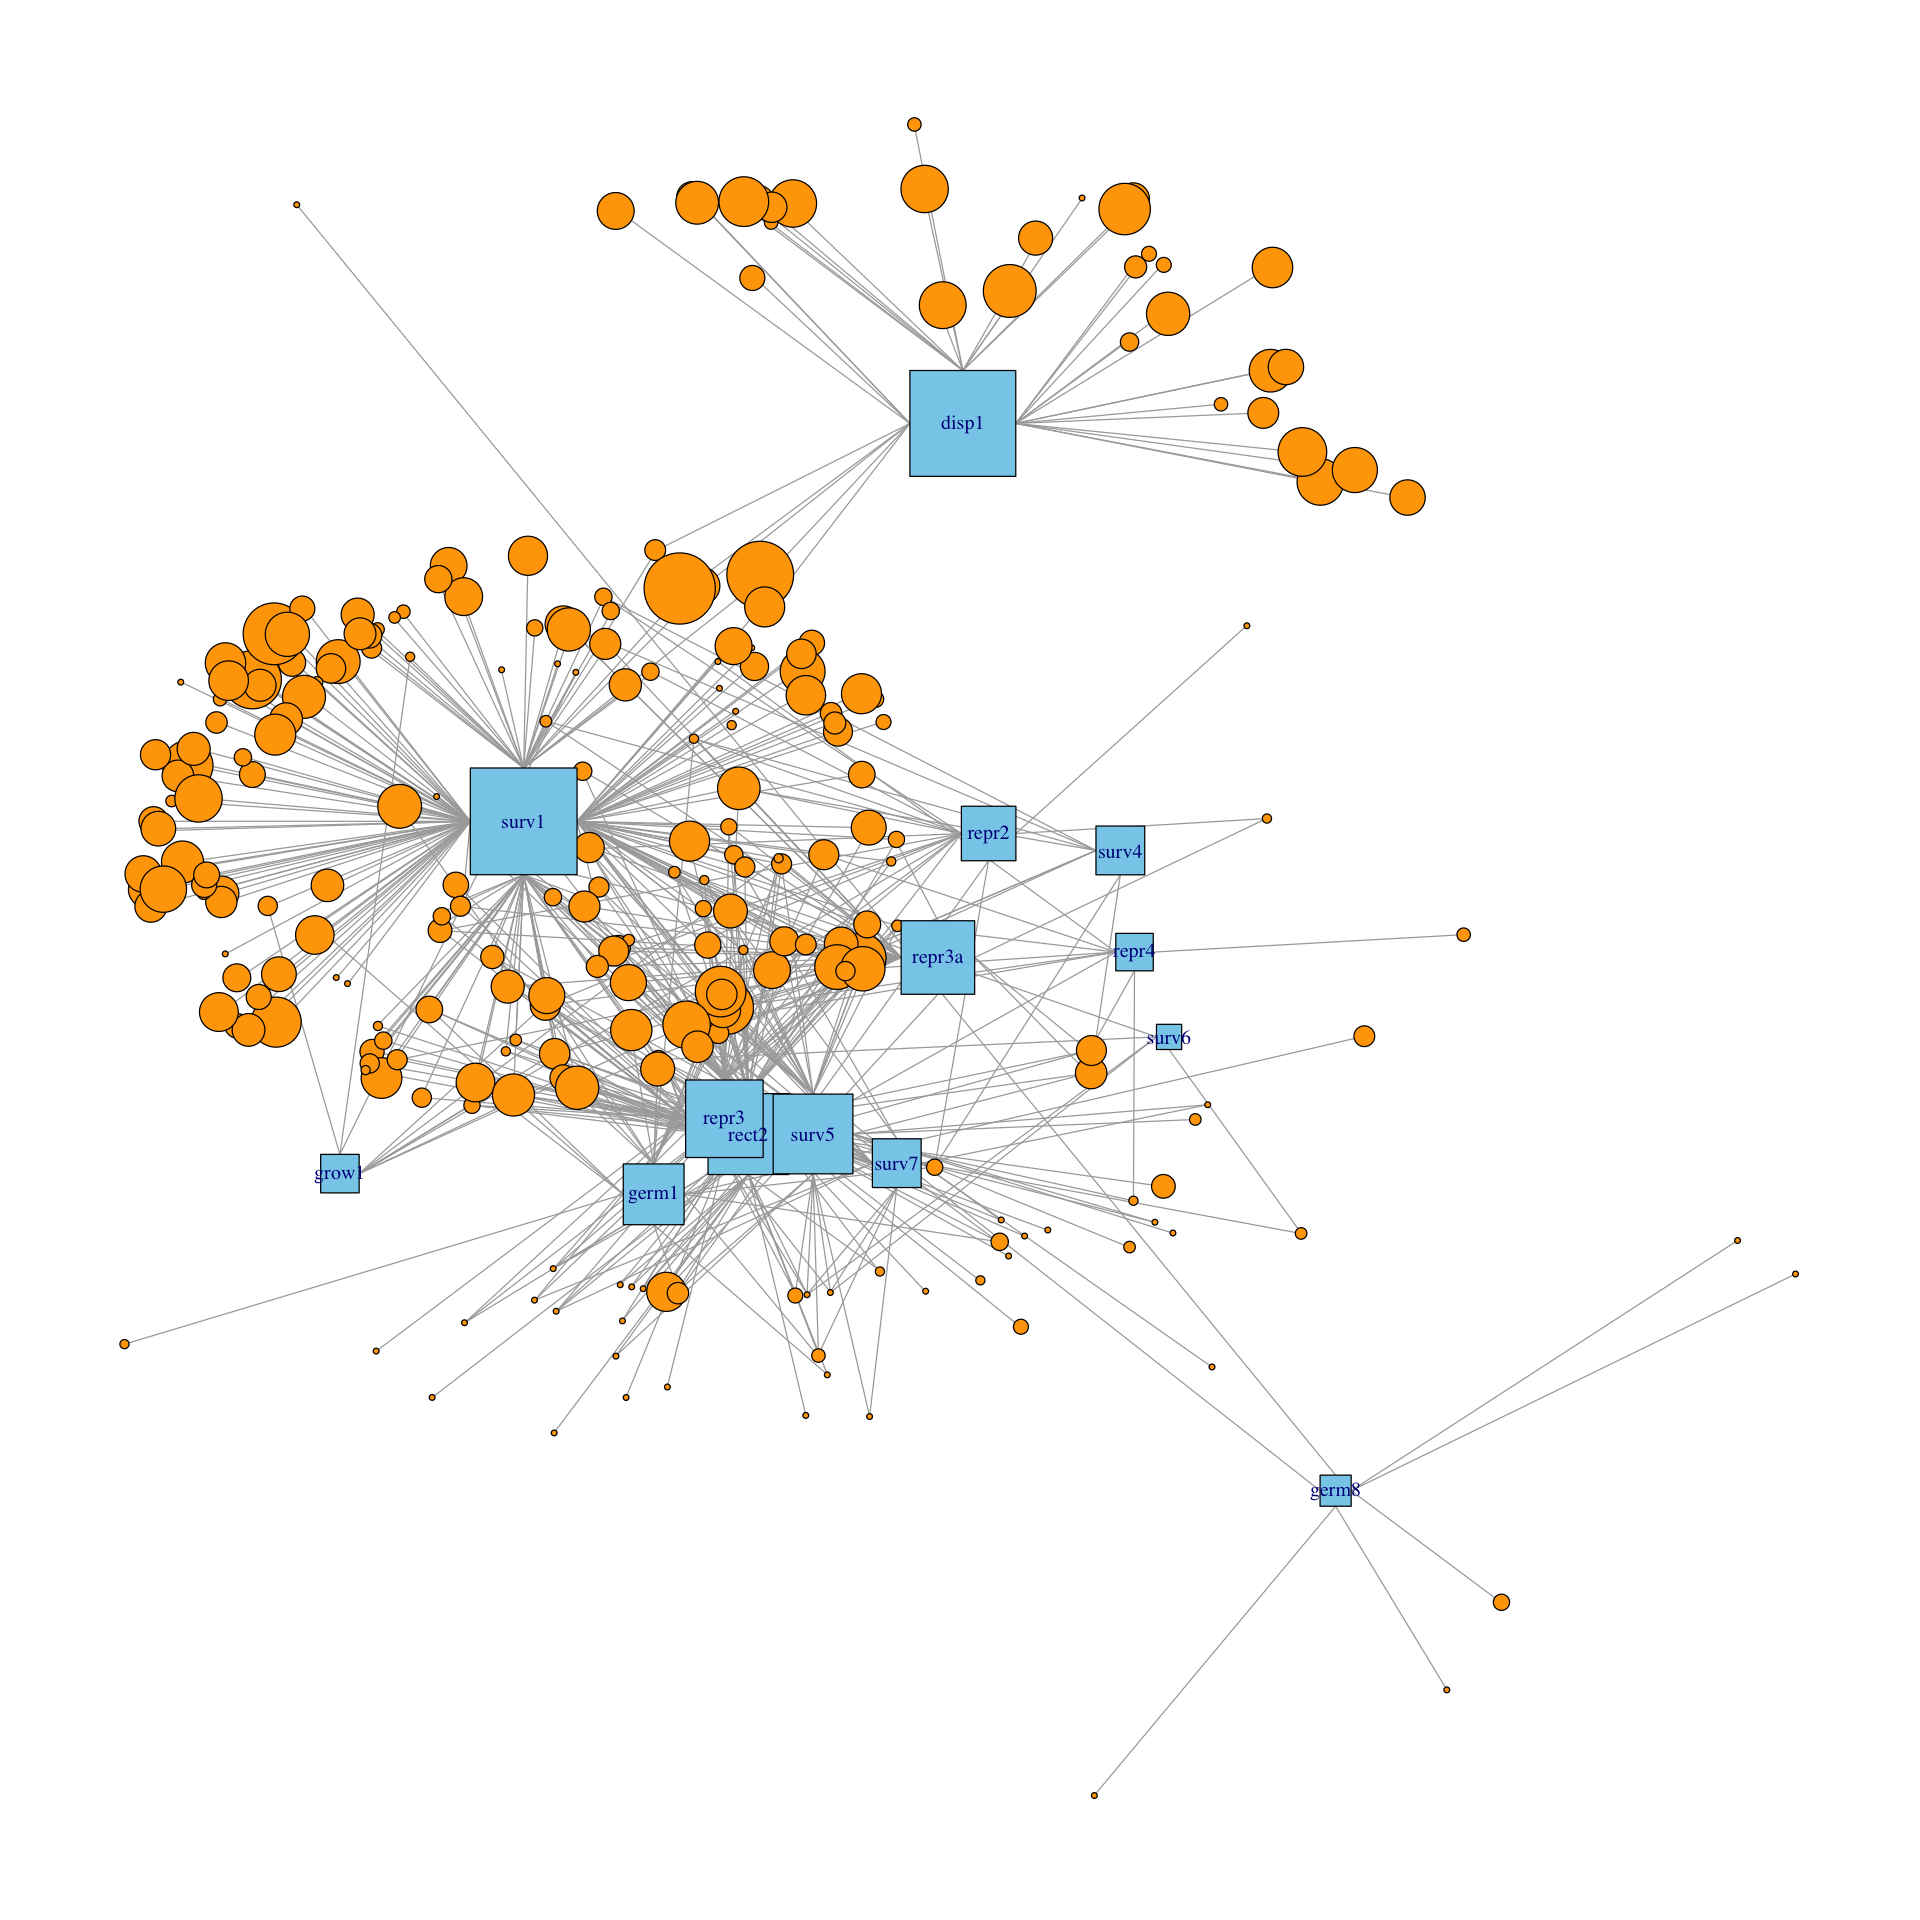

In [29]:
options(repr.plot.width=16, repr.plot.height=16) # Make plot larger

l <- layout_with_kk(traits_graph)
#l <- layout_nicely(g)
par(mar=c(0,0,0,0))
plot(traits_graph, layout=l,vertex.label.cex=1)

### Visualisation with ggraph

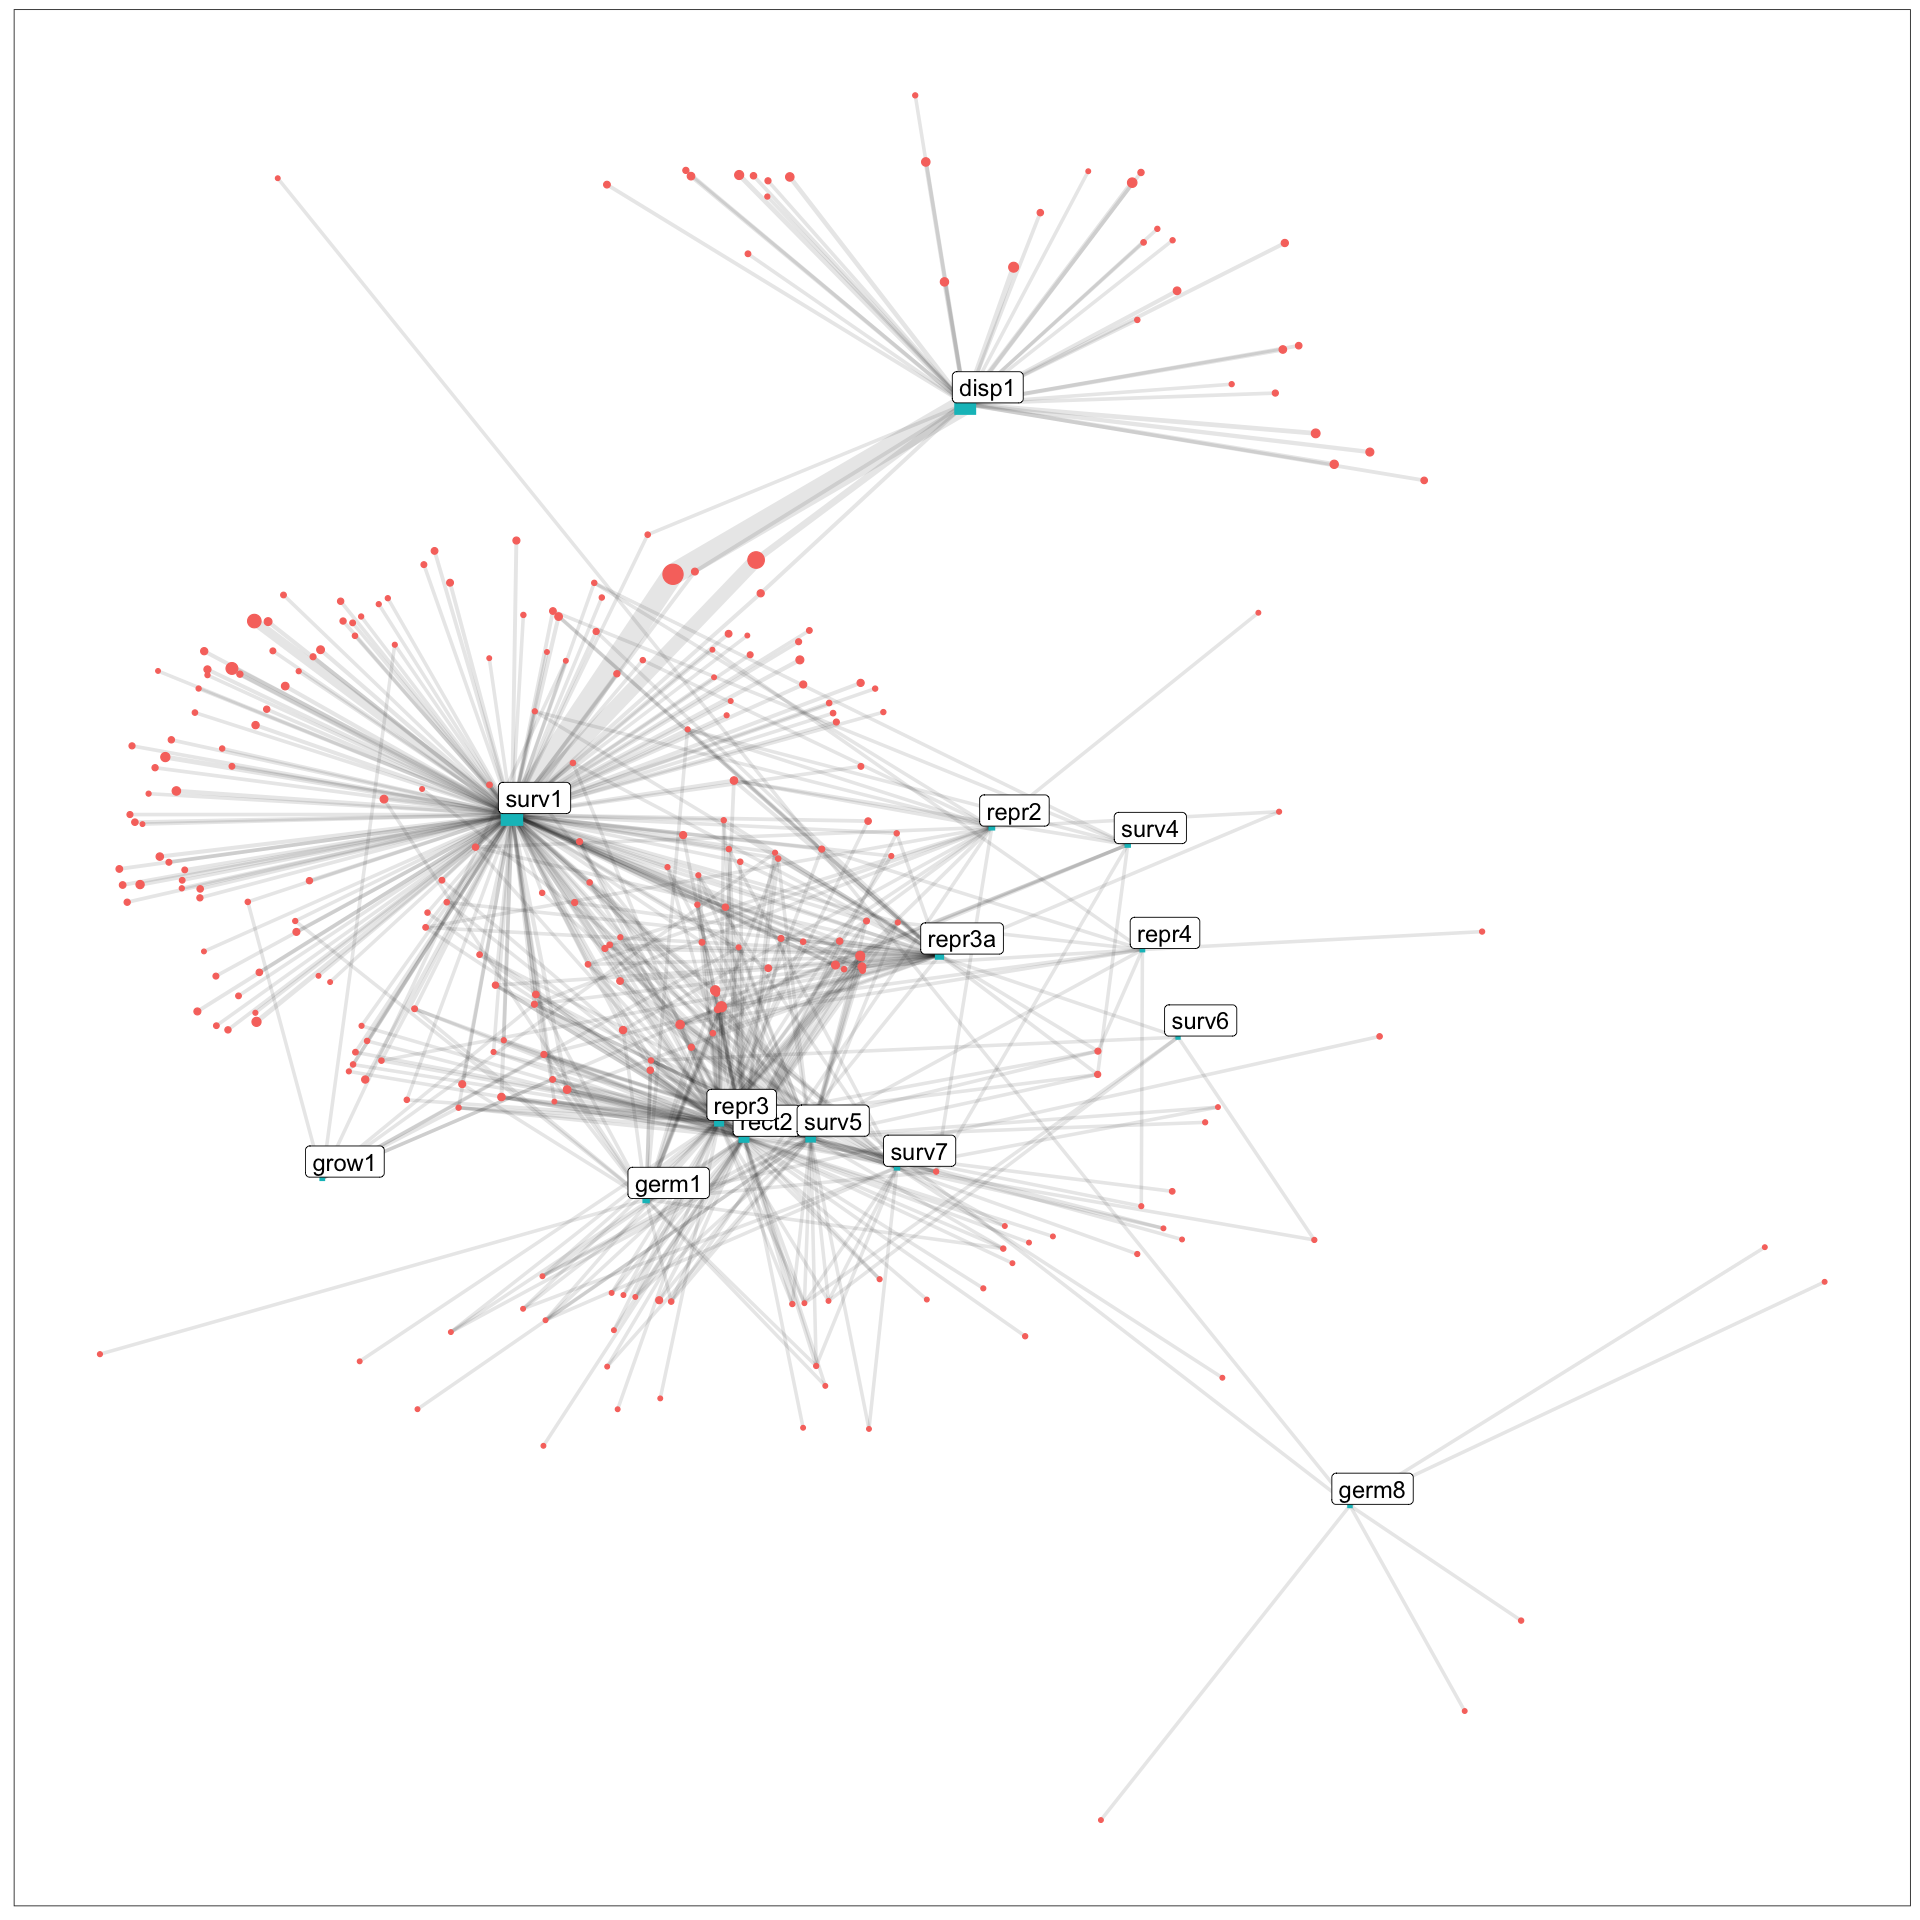

In [28]:
ggraph(traits_graph, 'igraph', algorithm = 'kk')+ 
  geom_edge_link0(aes(width = spp), edge_alpha = 0.1) + 
  geom_node_point(aes(size = spp, colour=type, shape = type)) + 
  scale_shape_manual(values=c("ref" = 19,  "trait" = 15)) +
  geom_node_label(aes(label = name, 
                      filter = type %in% "trait"), 
                  nudge_x = 0.25,
                  nudge_y = 0.25,
                 size = 5) + 
  ggforce::theme_no_axes() +
  theme(legend.position = "none") 